# Questions to answer
- [Q1]: Are there distributional differences between categories?
  - I noticed that raw data is skewed towards finance, sports, and travel. What is the distribution of the synthesized dataset?
- [Q2]: Are there differences between, say, tools data vs. finance in terms of lexical variations, API/question diversity, length
- [Q3]: What is the distribution of questions of naturally existing data vs. synthesized data?
  - lexical variations, question diversity, “difficulty” (how to measure?)
- [Q4]: How to improve query diversity? How to move beyond queries LLM can generate?
  - e.g. local search around generated API? can also exhaustive search but probably expensive
  - idea is to verify queries that LLMs are not able to generate
- [Q5]: How to go to multi-turn from single-turn? For instance compositional API calling dataset?

In [1]:
from datasets import load_dataset
apigen_datasets = load_dataset("Salesforce/xlam-function-calling-60k")['train']
print(f"Features are {apigen_datasets.features}")

/h/arthur/micromamba/envs/apigen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Features are {'query': Value(dtype='string', id=None), 'id': Value(dtype='int64', id=None), 'answers': Value(dtype='string', id=None), 'tools': Value(dtype='string', id=None)}


In [2]:
# let's classify the data into different categories
# we can only classify the data into all 4 categories: 1) simple, 2) multiple, 3) parallel, 4) multiple parallel
# although the data is not labeled
# 1) it's simple if it contains only one function call in the answer, and the tool list only contains one tool
# 2) it's multiple if it contains only one function call in the answer, and the tool list contains multiple tools
# 3) it's parallel if it contains multiple function calls in the answer, and the tool list only contains one tool
# 4) it's parallel multiple if it contains multiple function calls in the answer, and the tool list contains multiple tools
import json


def classify_apigen_data(datasets, duplicated_tool_names_idxes: list[int]) -> dict:
    result = {'simple': [], 'multiple': [], 'parallel': [], 'parallel_multiple': []}
    for item in datasets:
        answers = json.loads(item['answers'])
        answer_names = [answer['name'] for answer in answers]

        tools = json.loads(item['tools'])
        tool_names = [tool['name'] for tool in tools]
        tool_parameters = [tool['parameters'] for tool in tools]
        # check if there is function overload
        if len(set(tool_names)) != len(tool_names):
            duplicated_tool_names_idxes.append(item['id'])

        if len(answer_names) == 1 and len(tool_names) == 1:
            result['simple'].append(item)
        elif len(answer_names) == 1 and len(tool_names) > 1:
            result['multiple'].append(item)
        elif len(answer_names) > 1 and len(tool_names) == 1:
            result['parallel'].append(item)
        elif len(answer_names) > 1 and len(tool_names) > 1:
            result['parallel_multiple'].append(item)
    return result

duplicated_tool_names_idxes = []

apigen_datasets_classified = classify_apigen_data(apigen_datasets, duplicated_tool_names_idxes)
print(f"There are {len(duplicated_tool_names_idxes)} duplicated tool names (i.e., override functions)\n")

for type_ in apigen_datasets_classified.keys():
    print(f"There are {len(apigen_datasets_classified[type_])} {type_} data")


There are 260 duplicated tool names (i.e., override functions)

There are 8023 simple data
There are 20438 multiple data
There are 7387 parallel data
There are 24152 parallel_multiple data


## Q1: Are there distributional differences between categories?



In [15]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(datasets['train']['query'])

In [ ]:
# do a pca to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

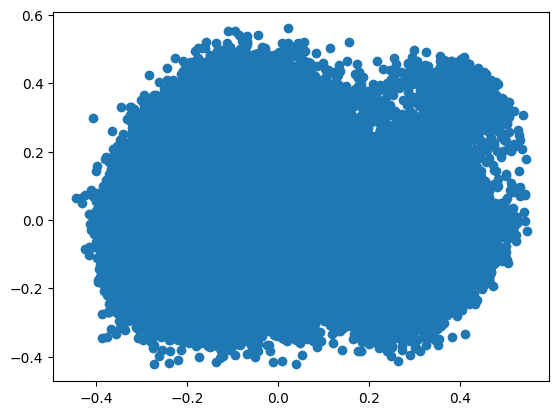

In [20]:
# plot
import matplotlib.pyplot as plt
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()

## Q3: What is the distribution of questions of naturally existing data vs. synthesized data?
  - lexical variations, question diversity, “difficulty” (how to measure?)

#### Load real data from BFCL

In [15]:
import json
from glob import glob
import os

REAL_DATA_PATTERN = "/h/arthur/Workspace/apigen/gorilla/berkeley-function-call-leaderboard/data/BFCL_v3_live_*.json"
REAL_DATA_ANSWER_PATTERN = "/h/arthur/Workspace/apigen/gorilla/berkeley-function-call-leaderboard/data/possible_answer/BFCL_v3_live_*.json"
REAL_DATA_PATHS = [path for path in glob(REAL_DATA_PATTERN) if 'irrelevance' not in path and 'relevance' not in path]
REAL_DATA_ANSWERS_PATHS = [path for path in glob(REAL_DATA_ANSWER_PATTERN) if 'irrelevance' not in path and 'relevance' not in path]

question_types = [os.path.basename(path).replace('BFCL_v3_live_', '').replace('.json', '') for path in REAL_DATA_PATHS]
answer_types = [os.path.basename(path).replace('BFCL_v3_live_', '').replace('.json', '') for path in REAL_DATA_ANSWERS_PATHS]

print(f"Question types: {question_types}")
print(f"Answer types: {answer_types}")


def load_file(file_path: str):
    result = []
    with open(file_path) as f:
        file = f.readlines()
        for line in file:
            result.append(json.loads(line))
    return result

real_data = {type_: load_file(path) for type_, path in zip(question_types, REAL_DATA_PATHS)}
real_data_answers = {type_: load_file(path) for type_, path in zip(answer_types, REAL_DATA_ANSWERS_PATHS)}
assert len(real_data.keys()) == len(real_data_answers.keys()), f"Length of data and answers are not the same, {len(real_data)} vs {len(real_data_answers)}"

for type_ in real_data.keys():
    print(f"Length of \"{type_}\" data is {len(real_data[type_])}")
    assert len(real_data[type_]) == len(real_data_answers[type_]), f"Length of data and answers are not the same for {type_}, {len(real_data[type_])} vs {len(real_data_answers[type_])}"


Question types: ['multiple', 'simple', 'parallel_multiple', 'parallel']
Answer types: ['multiple', 'simple', 'parallel_multiple', 'parallel']
Length of "multiple" data is 1037
Length of "simple" data is 258
Length of "parallel_multiple" data is 24
Length of "parallel" data is 16


#### Query statistics
let's look at the query length distribution, we will look at 
1. from the term frequency perspective, 
2. from the semantic perspective (e.g. using embeddings)


#### Real Data from BFCL

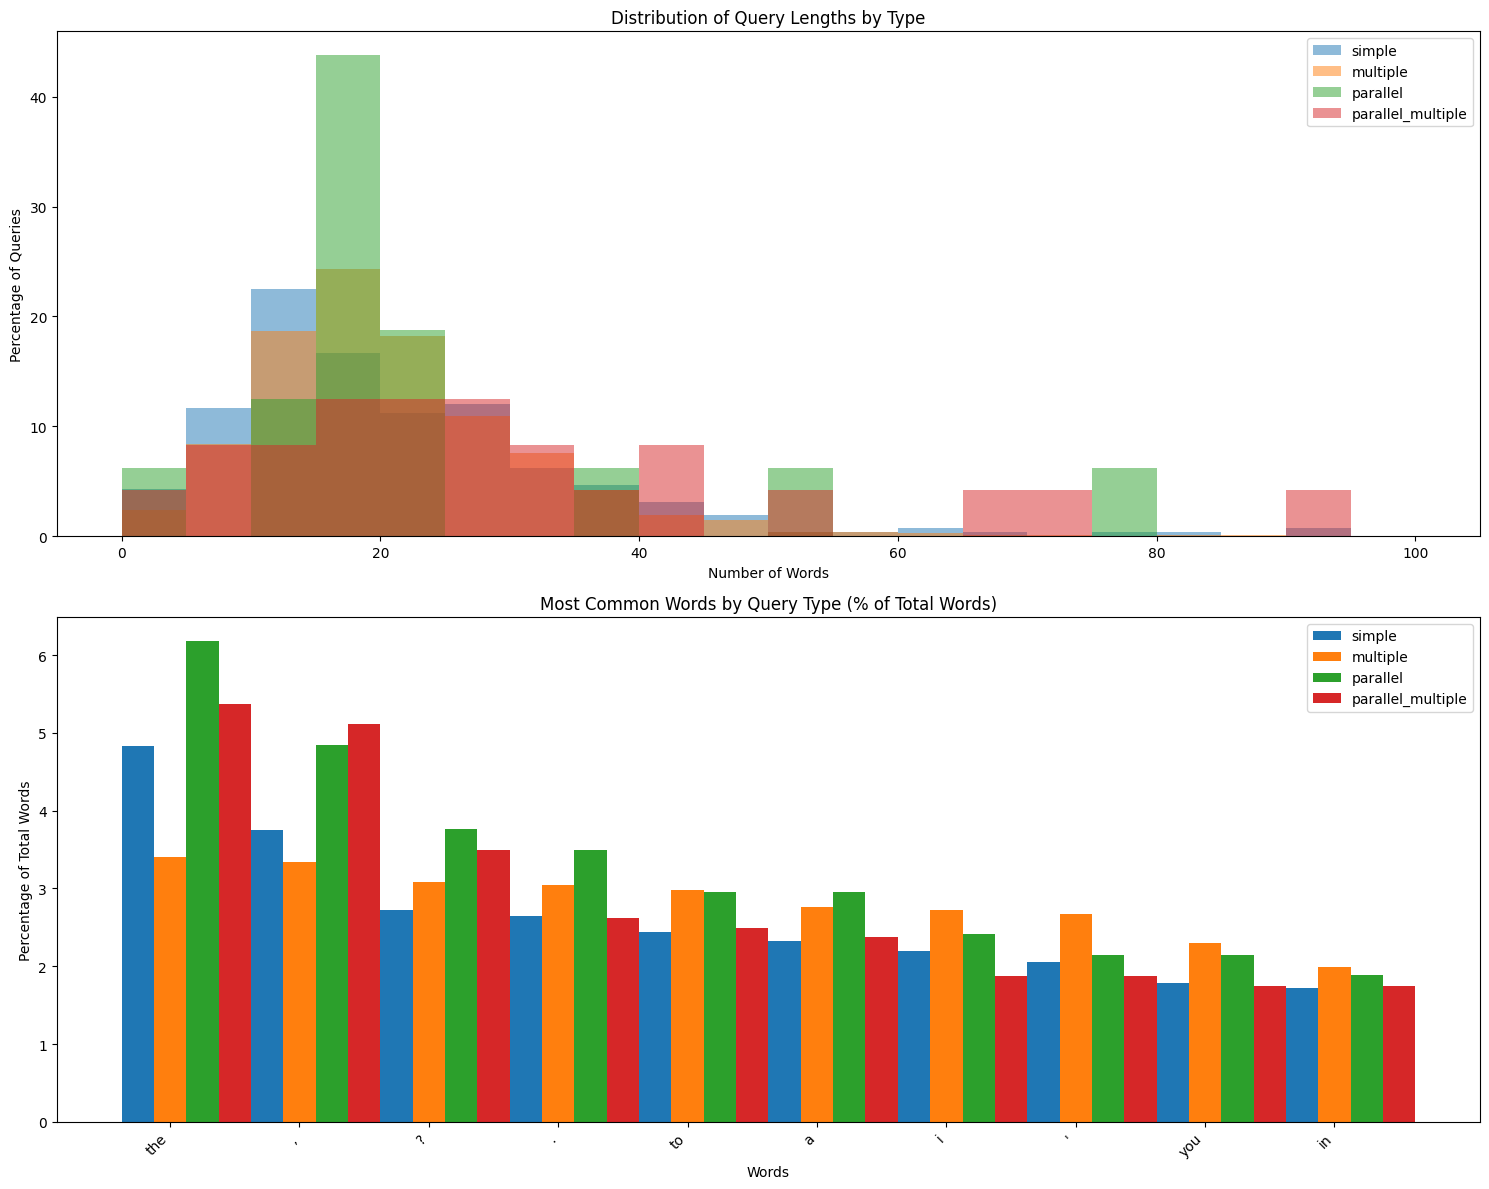

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

def get_bfcl_question(item):
    question = item['question'][0][-1]
    assert len(question) <= 2, f"There should be only one question in the data, but got {len(question)}, {question}"
    return question['content']

# Analyze queries for all types
data_types = ['simple', 'multiple', 'parallel', 'parallel_multiple']
queries_by_type = {
    type_: [get_bfcl_question(item) for item in real_data[type_]]
    for type_ in data_types
}

# Create subplots for length distribution and word frequency
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Query length distributions
for type_ in data_types:
    query_lengths = [len(word_tokenize(query)) for query in queries_by_type[type_]]
    # Convert to percentages by normalizing by total count
    weights = np.ones_like(query_lengths) / len(query_lengths) * 100
    axes[0].hist(query_lengths, bins=20, alpha=0.5, label=type_, range=(0, 100), weights=weights)

axes[0].set_title('Distribution of Query Lengths by Type')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Percentage of Queries')
axes[0].legend()

# Plot 2: Most common words comparison
word_freq_by_type = {}
for type_ in data_types:
    # Count total words for this type
    all_words = [word.lower() for query in queries_by_type[type_] 
                 for word in word_tokenize(query)]
    total_words = len(all_words)
    
    # Get frequencies and convert to percentages
    word_counts = Counter(all_words).most_common(10)
    word_freq_by_type[type_] = [(word, (count/total_words)*100) for word, count in word_counts]

x = np.arange(10)
width = 0.25
for i, type_ in enumerate(data_types):
    axes[1].bar(x + i*width, 
                [percentage for word, percentage in word_freq_by_type[type_]], 
                width, 
                label=type_)
    if i == 0:
        axes[1].set_xticks(x + width)
        axes[1].set_xticklabels([word for word, _ in word_freq_by_type[type_]], 
                               rotation=45, 
                               ha='right')

axes[1].set_title('Most Common Words by Query Type (% of Total Words)')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Percentage of Total Words')
axes[1].legend()

plt.tight_layout()
plt.show()

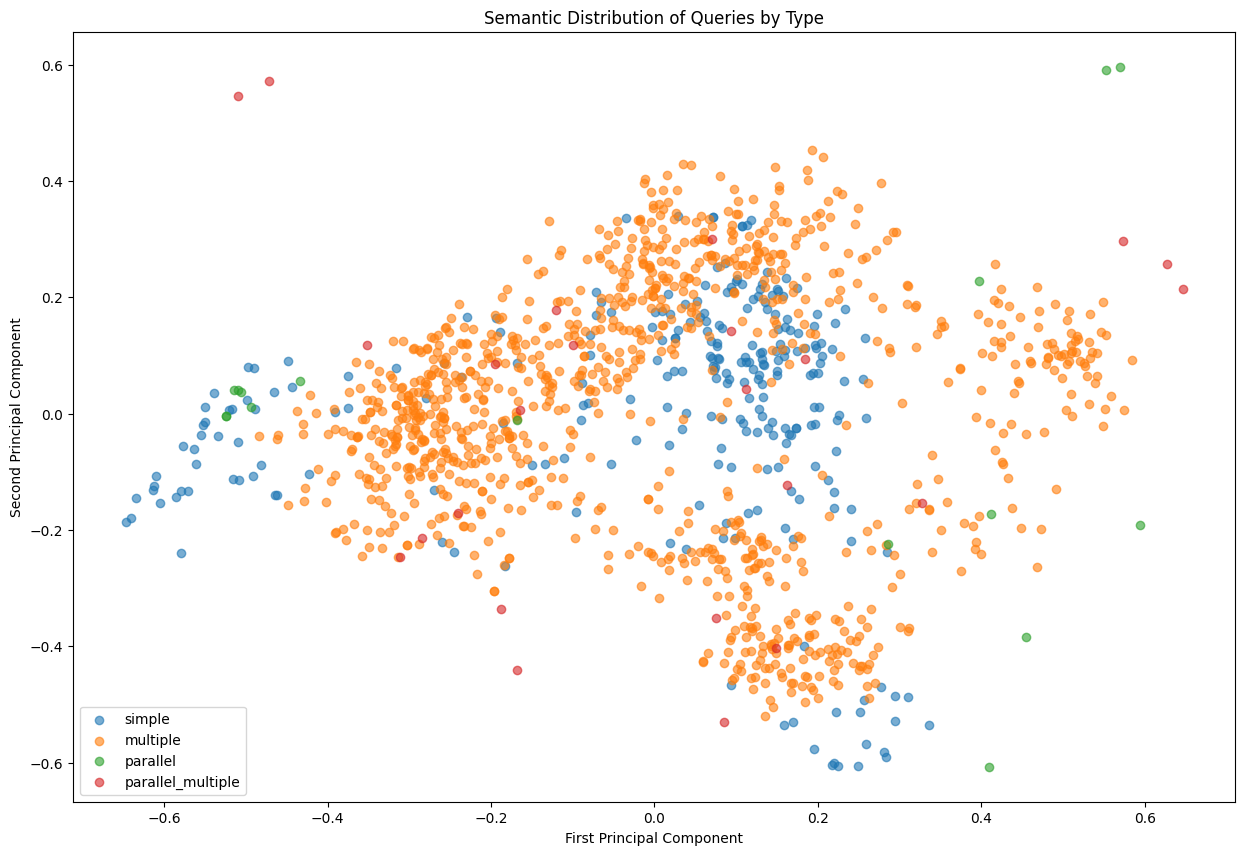

In [14]:
# 2. from the semantic perspective
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create plots for each type
plt.figure(figsize=(15, 10))

for type_name, queries in queries_by_type.items():
    # Get embeddings for this type's queries
    type_embeddings = model.encode(queries)
    
    # Reduce dimensionality with PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(type_embeddings)
    
    # Plot with different color/marker for each type
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
               alpha=0.6, label=type_name)

plt.title('Semantic Distribution of Queries by Type')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

#### APIGen Data (i.e., synthesized data)

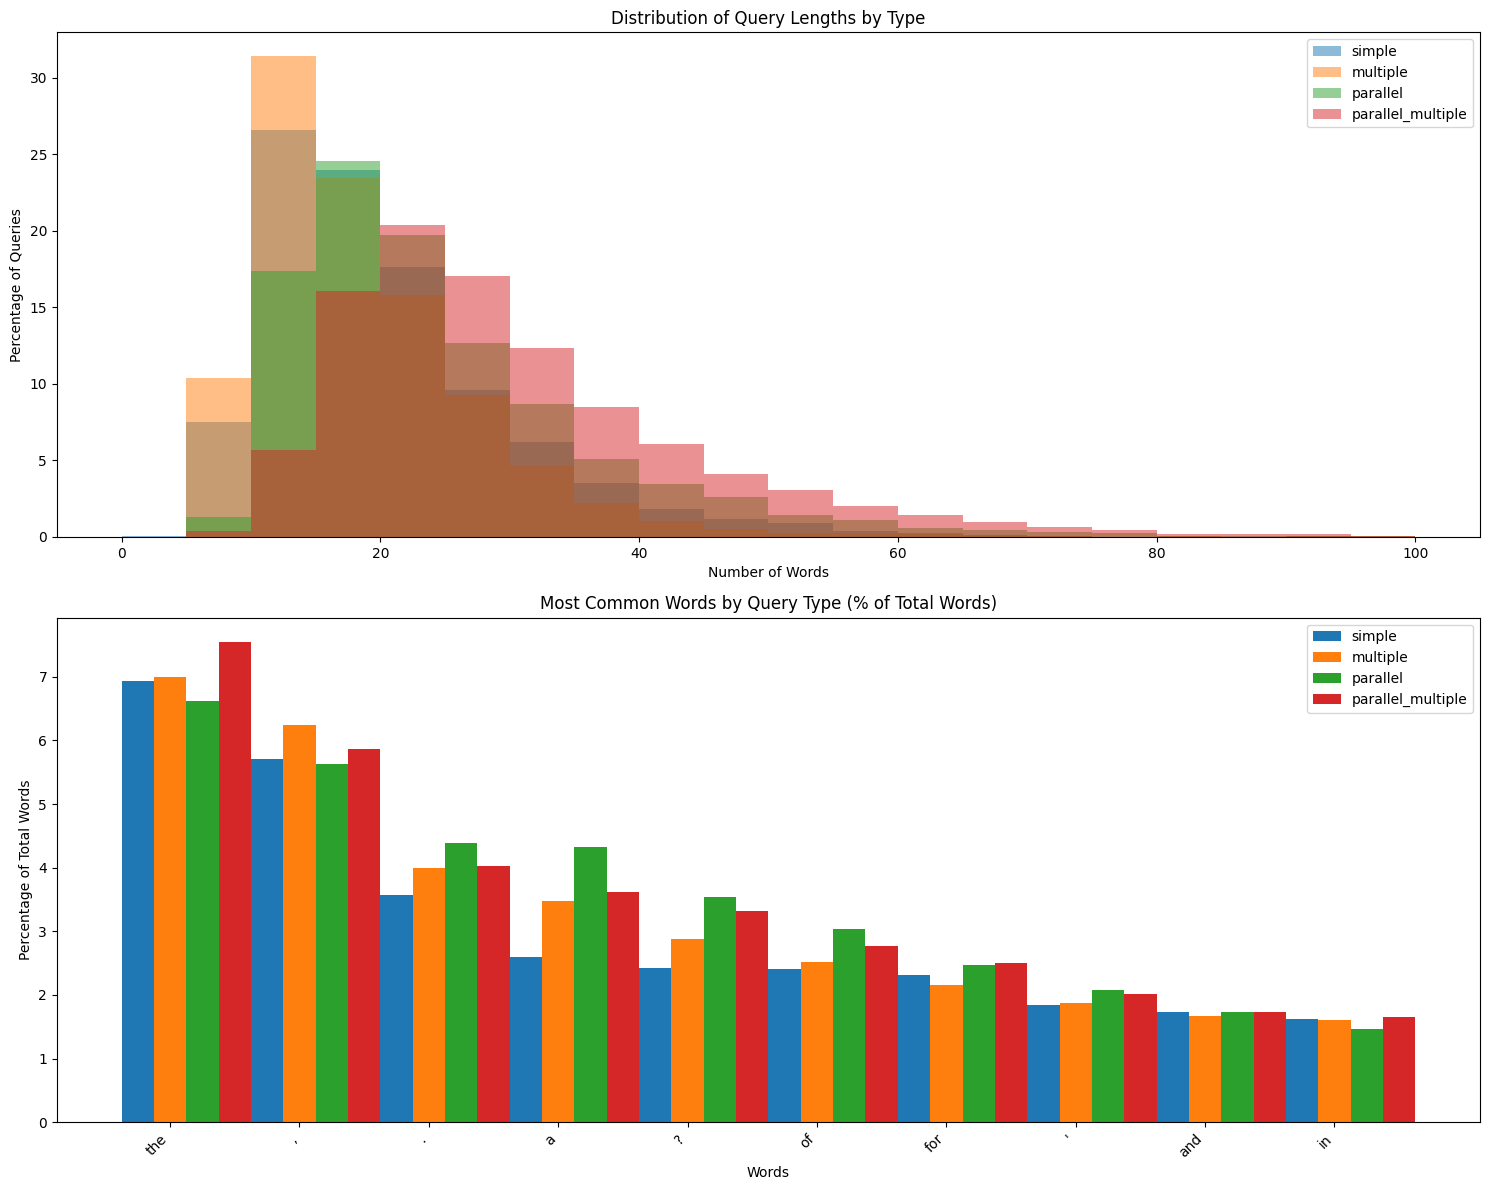

In [5]:
# Do the same thing for apigen data

def get_apigen_question(item):
    question = item['query']
    return question

# Analyze queries for all types
data_types = ['simple', 'multiple', 'parallel', 'parallel_multiple']
queries_by_type = {
    type_: [get_apigen_question(item) for item in apigen_datasets_classified[type_]]
    for type_ in data_types
}

# Create subplots for length distribution and word frequency
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Query length distributions
for type_ in data_types:
    query_lengths = [len(word_tokenize(query)) for query in queries_by_type[type_]]
    # Convert to percentages by normalizing by total count
    weights = np.ones_like(query_lengths) / len(query_lengths) * 100
    axes[0].hist(query_lengths, bins=20, alpha=0.5, label=type_, range=(0, 100), weights=weights)

axes[0].set_title('Distribution of Query Lengths by Type')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Percentage of Queries')
axes[0].legend()

# Plot 2: Most common words comparison
word_freq_by_type = {}
for type_ in data_types:
    # Count total words for this type
    all_words = [word.lower() for query in queries_by_type[type_] 
                 for word in word_tokenize(query)]
    total_words = len(all_words)
    
    # Get frequencies and convert to percentages
    word_counts = Counter(all_words).most_common(10)
    word_freq_by_type[type_] = [(word, (count/total_words)*100) for word, count in word_counts]

x = np.arange(10)
width = 0.25
for i, type_ in enumerate(data_types):
    axes[1].bar(x + i*width, 
                [percentage for word, percentage in word_freq_by_type[type_]], 
                width, 
                label=type_)
    if i == 0:
        axes[1].set_xticks(x + width)
        axes[1].set_xticklabels([word for word, _ in word_freq_by_type[type_]], 
                               rotation=45, 
                               ha='right')

axes[1].set_title('Most Common Words by Query Type (% of Total Words)')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Percentage of Total Words')
axes[1].legend()

plt.tight_layout()
plt.show()

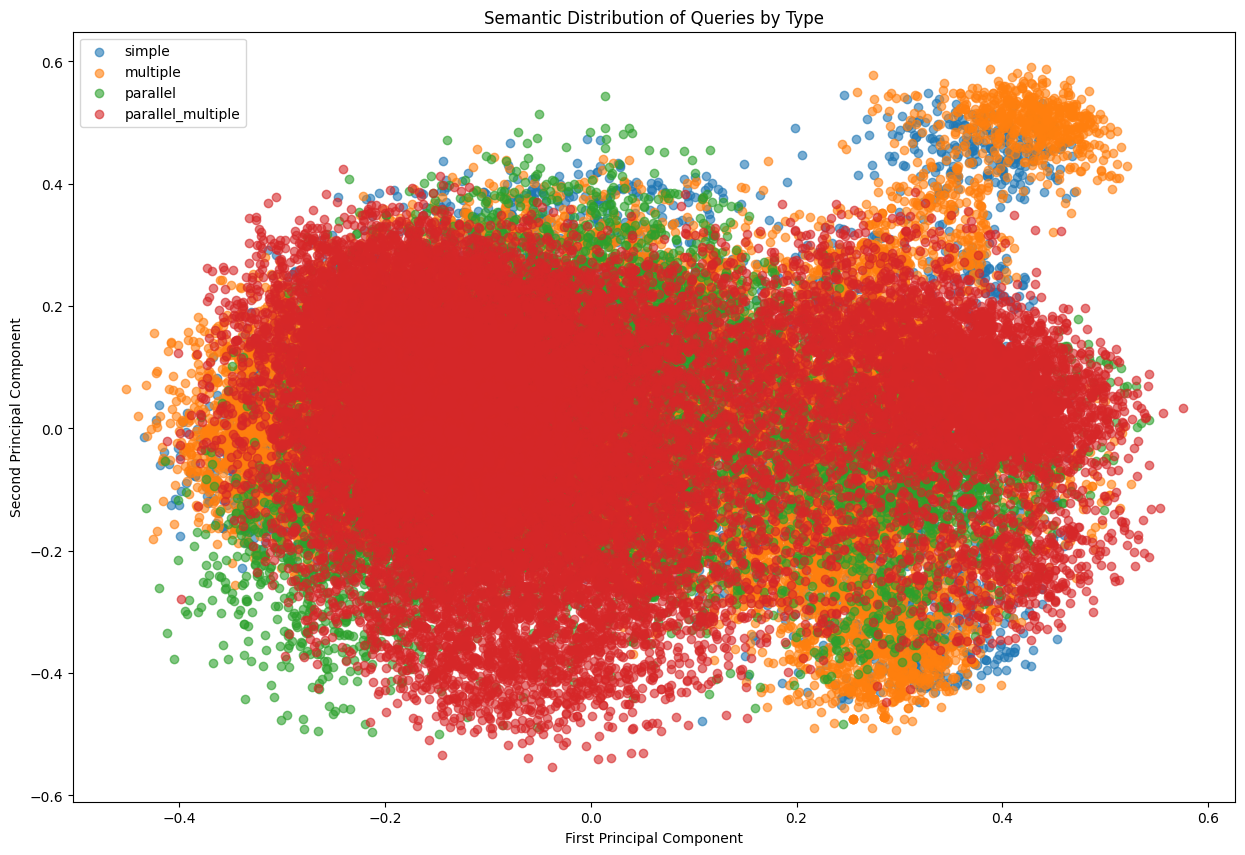

In [16]:
# 2. from the semantic perspective
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create plots for each type
plt.figure(figsize=(15, 10))

for type_name, queries in queries_by_type.items():
    # Get embeddings for this type's queries
    type_embeddings = model.encode(queries)
    
    # Reduce dimensionality with PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(type_embeddings)
    
    # Plot with different color/marker for each type
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
               alpha=0.6, label=type_name)

plt.title('Semantic Distribution of Queries by Type')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

#### Side by side comparison between real data and apigen data

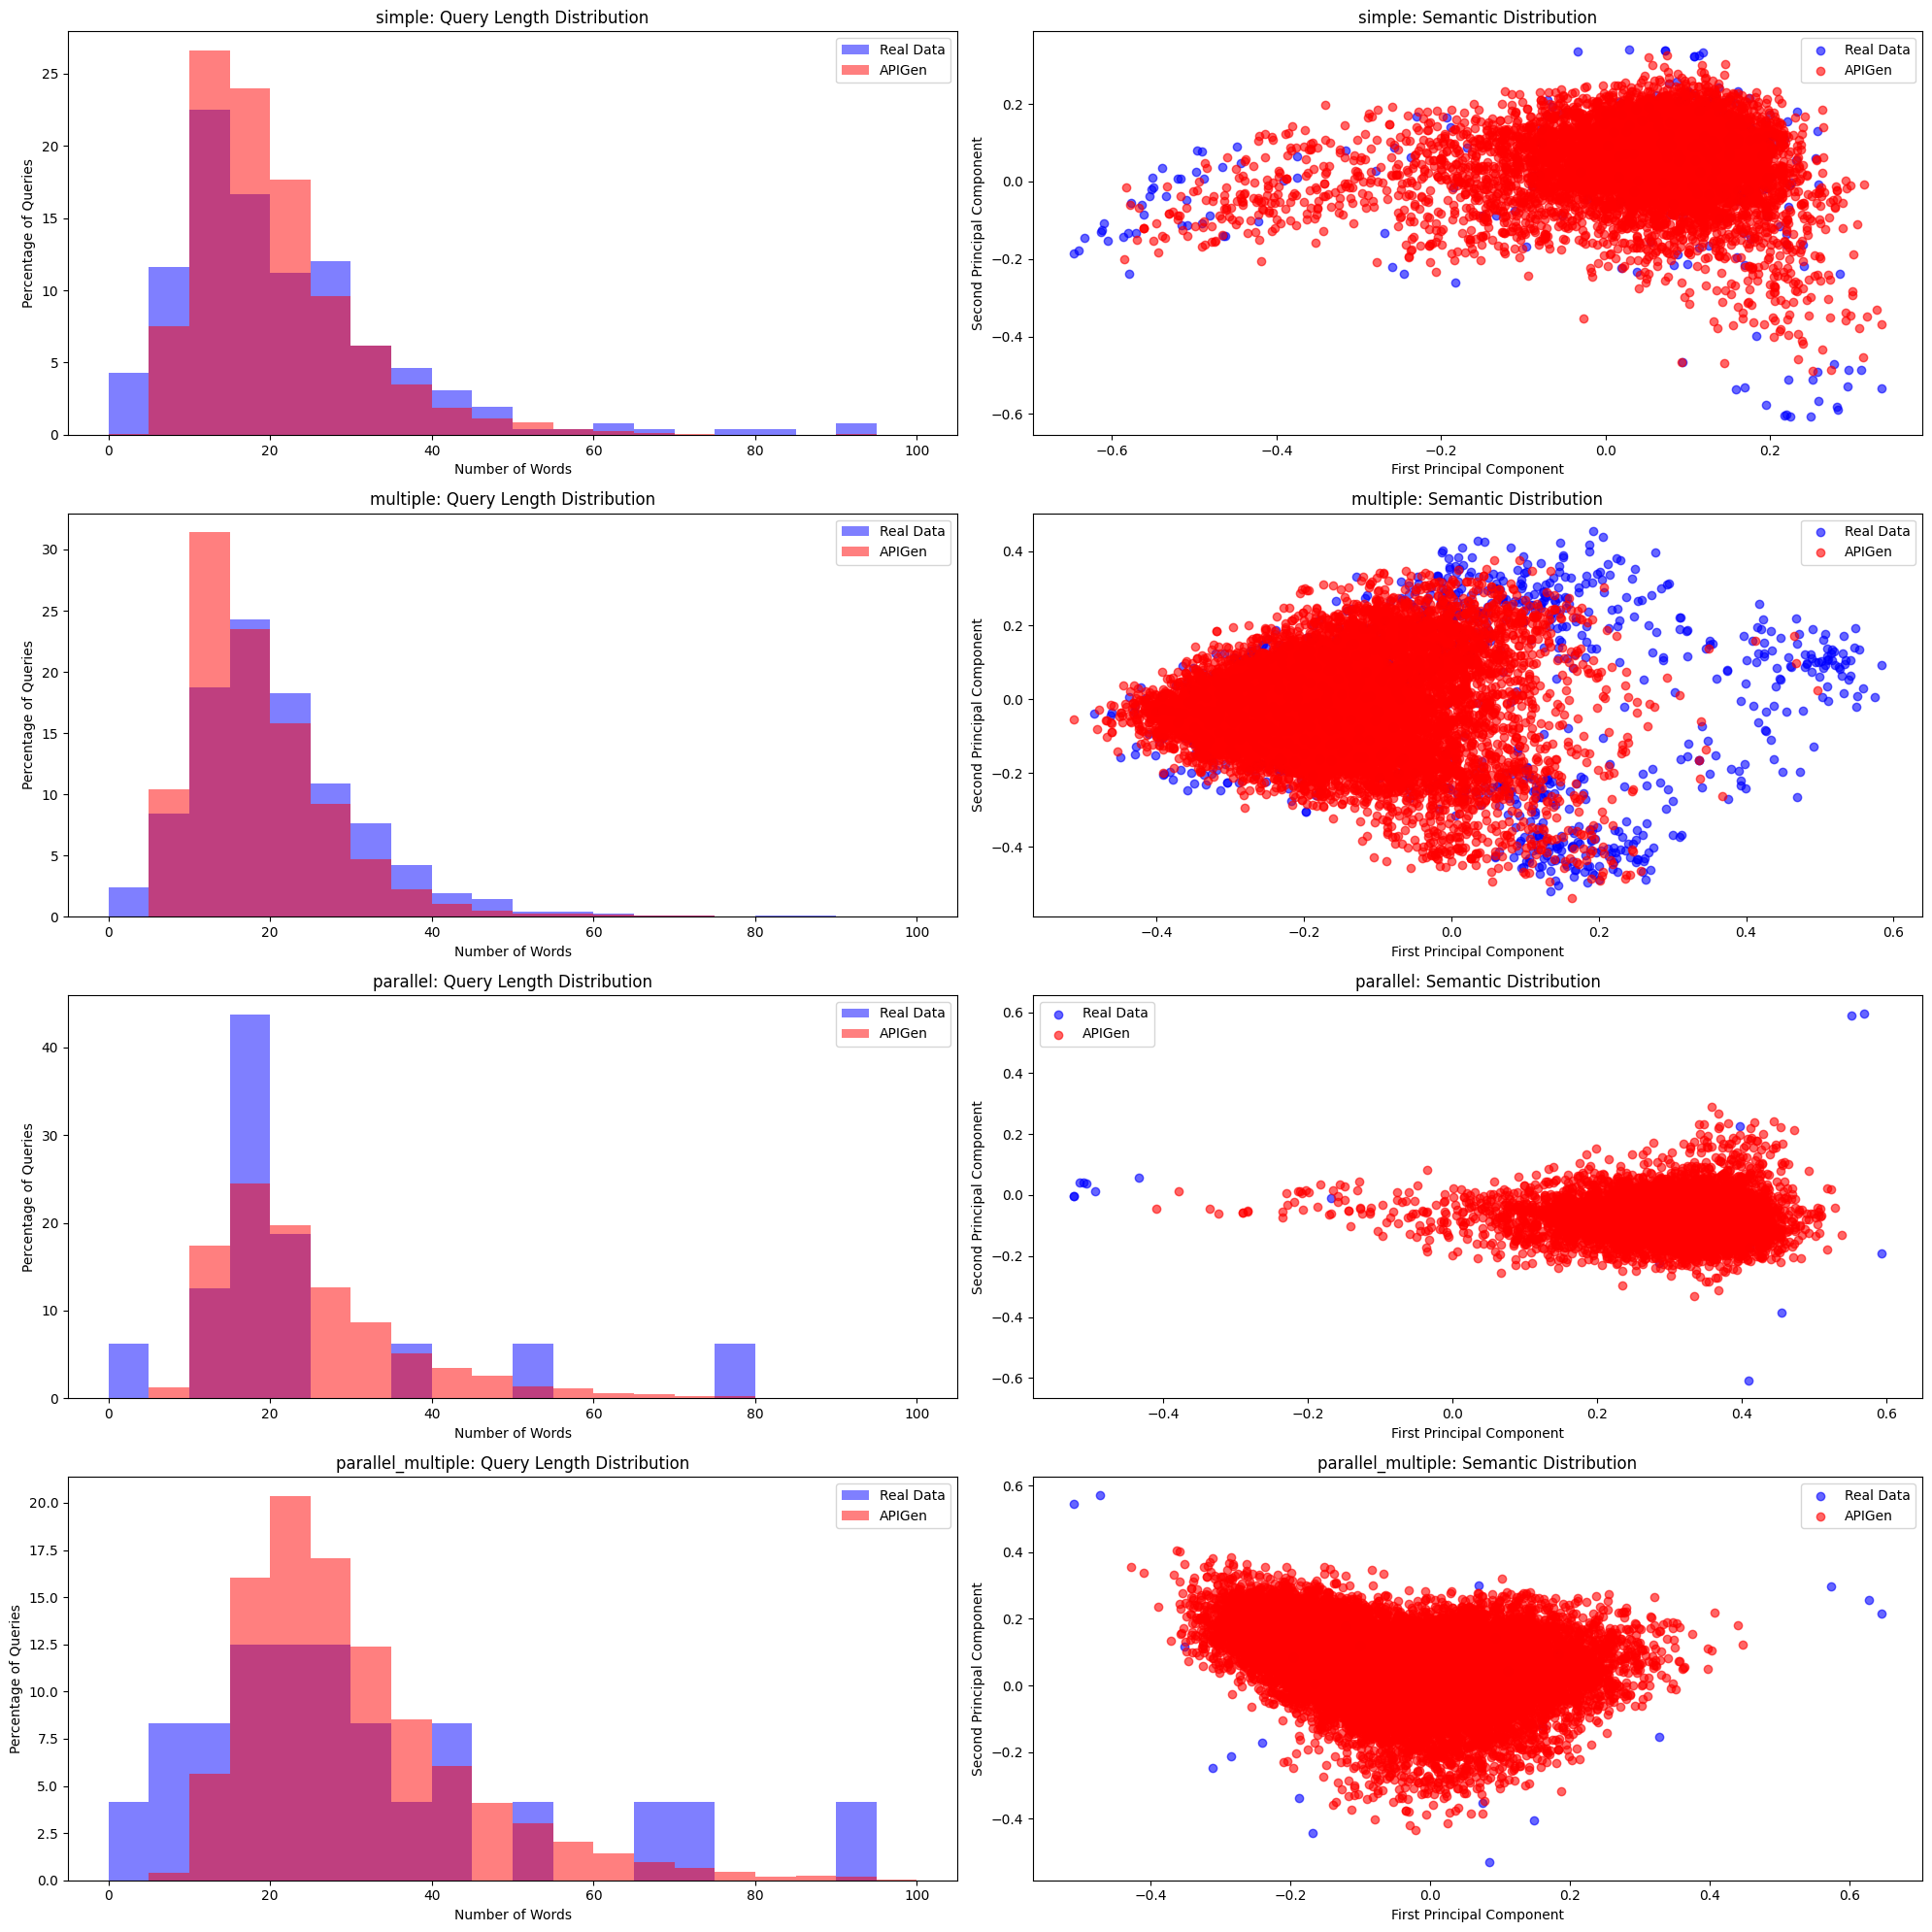

In [6]:
# Function to get questions from both datasets
def get_bfcl_question(item):
    question = item['question'][0][-1]
    assert len(question) <= 2, f"There should be only one question in the data, but got {len(question)}, {question}"
    return question['content']

def get_apigen_question(item):
    return item['query']

# Create side-by-side comparison for each type
data_types = ['simple', 'multiple', 'parallel', 'parallel_multiple']

# Load model for embedding
model = SentenceTransformer('all-MiniLM-L6-v2')

# Setup the plots
fig, axes = plt.subplots(len(data_types), 2, figsize=(20, 5*len(data_types)))

for idx, type_ in enumerate(data_types):
    # Get queries for both datasets
    real_queries = [get_bfcl_question(item) for item in real_data[type_]]
    apigen_queries = [get_apigen_question(item) for item in apigen_datasets_classified[type_]]
    
    # Plot 1: Query length distributions
    real_lengths = [len(word_tokenize(query)) for query in real_queries]
    apigen_lengths = [len(word_tokenize(query)) for query in apigen_queries]
    
    # Convert to percentages by normalizing
    real_weights = np.ones_like(real_lengths) / len(real_lengths) * 100
    apigen_weights = np.ones_like(apigen_lengths) / len(apigen_lengths) * 100
    
    axes[idx, 0].hist(real_lengths, bins=20, alpha=0.5, label='Real Data', 
                      range=(0, 100), color='blue', weights=real_weights)
    axes[idx, 0].hist(apigen_lengths, bins=20, alpha=0.5, label='APIGen', 
                      range=(0, 100), color='red', weights=apigen_weights)
    axes[idx, 0].set_title(f'{type_}: Query Length Distribution')
    axes[idx, 0].set_xlabel('Number of Words')
    axes[idx, 0].set_ylabel('Percentage of Queries')
    axes[idx, 0].legend()
    
    # Plot 2: Semantic Distribution
    real_embeddings = model.encode(real_queries)
    apigen_embeddings = model.encode(apigen_queries)
    
    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_embeddings)
    apigen_2d = pca.transform(apigen_embeddings)
    
    axes[idx, 1].scatter(real_2d[:, 0], real_2d[:, 1], alpha=0.6, label='Real Data', color='blue')
    axes[idx, 1].scatter(apigen_2d[:, 0], apigen_2d[:, 1], alpha=0.6, label='APIGen', color='red')
    axes[idx, 1].set_title(f'{type_}: Semantic Distribution')
    axes[idx, 1].set_xlabel('First Principal Component')
    axes[idx, 1].set_ylabel('Second Principal Component')
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()

#### Function statistics
For function statistics, we will look at the number of functions in the query, and the distribution of the number of functions in the query.

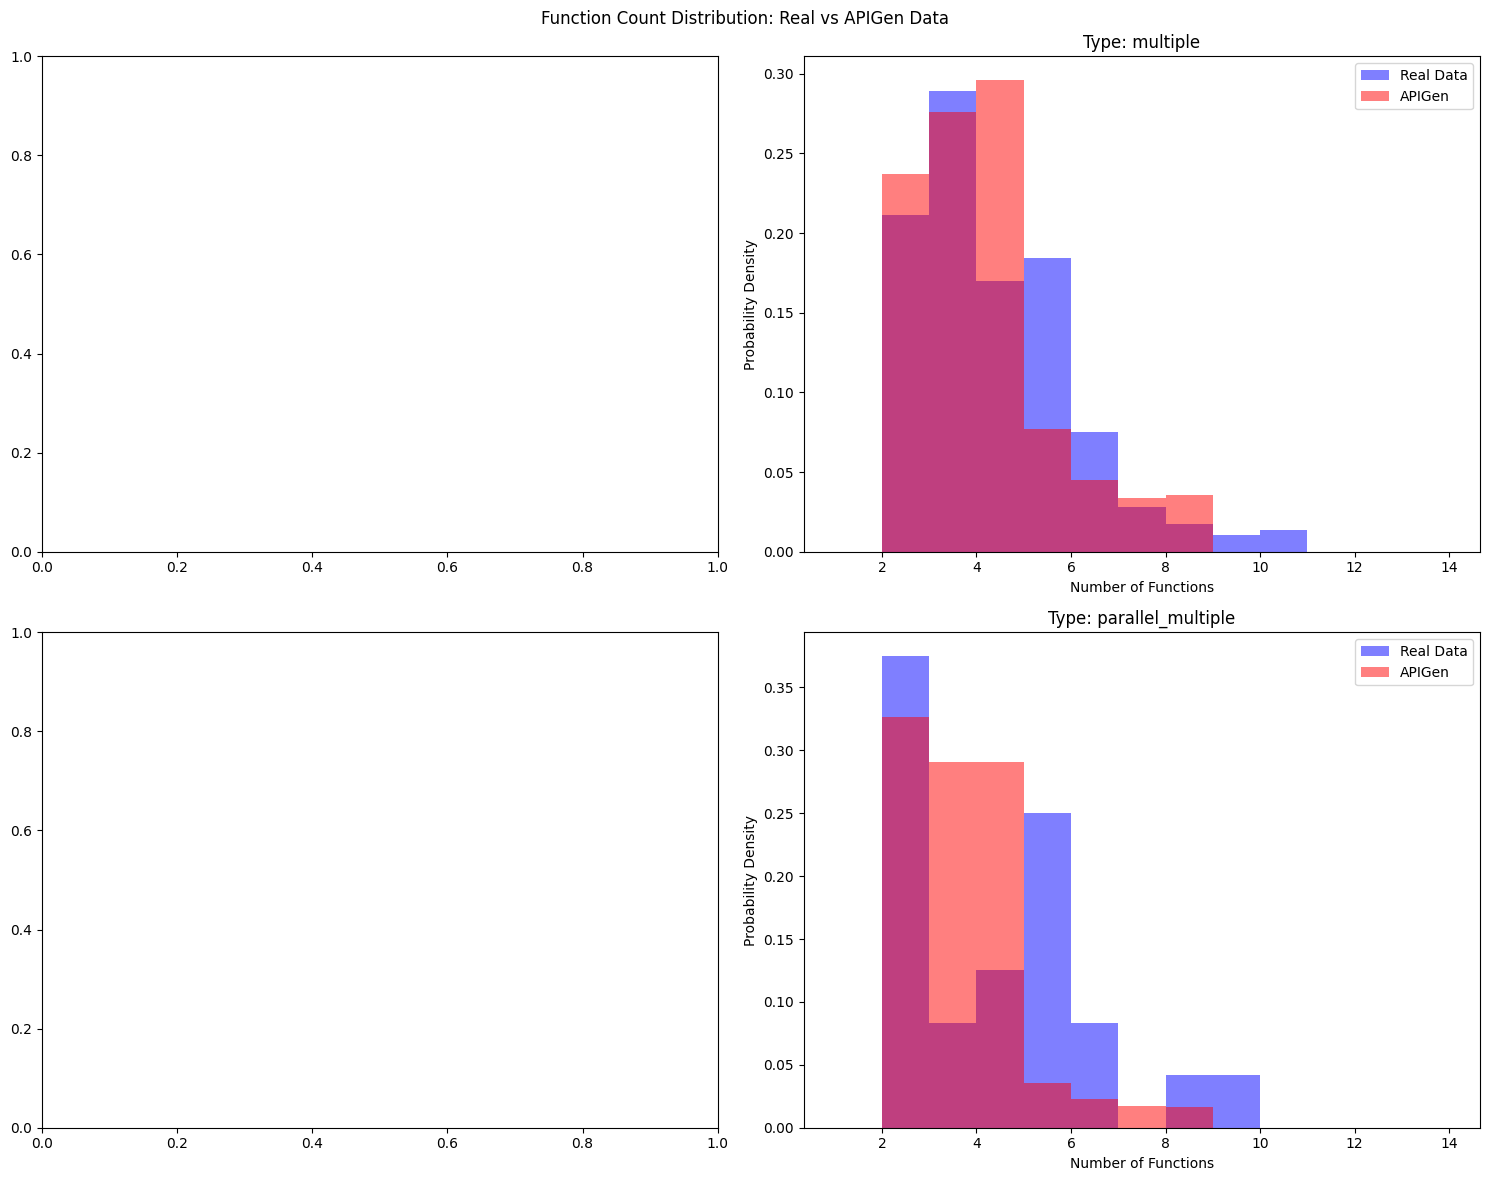

In [27]:
from scipy.stats import gaussian_kde

# Function to count functions in real data
def count_real_functions(item):
    return len(item['function'])

# Function to count functions in apigen data
def count_apigen_functions(item):
    answers = json.loads(item['tools'])
    return len(answers)

# Get function counts for both datasets
real_function_counts = {
    type_: [count_real_functions(item) for item in data]
    for type_, data in real_data.items()
}

apigen_function_counts = {
    type_: [count_apigen_functions(item) for item in data]
    for type_, data in apigen_datasets_classified.items()
}

# ... existing imports and function definitions ...

# Create subplot grid
multiple_bins = range(1, 15, 1)
skip_types = ['simple', 'parallel']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Function Count Distribution: Real vs APIGen Data')



# Plot histograms for each type
for idx, type_ in enumerate(data_types):
    if type_ in skip_types:
        continue
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Calculate normalized histograms (PDF)
    real_hist, real_bins = np.histogram(real_function_counts[type_], bins=20, density=True)
    apigen_hist, apigen_bins = np.histogram(apigen_function_counts[type_], bins=20, density=True)
    
    # Plot histograms
    if 'multiple' in type_:
        ax.hist(real_function_counts[type_], bins=multiple_bins, alpha=0.5, 
                label='Real Data', color='blue', density=True)
        ax.hist(apigen_function_counts[type_], bins=multiple_bins, alpha=0.5, 
                label='APIGen', color='red', density=True)
    else:
        ax.hist(real_function_counts[type_], bins=5, alpha=0.5, 
                label='Real Data', color='blue', density=True)
        ax.hist(apigen_function_counts[type_], bins=5, alpha=0.5, 
                label='APIGen', color='red', density=True)
    
    ax.set_title(f'Type: {type_}')
    ax.set_xlabel('Number of Functions')
    ax.set_ylabel('Probability Density')
    ax.legend()

plt.tight_layout()

#### Function call answer statistics
For function call answer statistics, we will look at:
1. the number of function calls in the answer
2. the number of arguments in the function call

In [11]:
# synthetic data
json.loads(apigen_datasets_classified['parallel'][0]['answers'])

[{'name': 'live_giveaways_by_type', 'arguments': {'type': 'beta'}},
 {'name': 'live_giveaways_by_type', 'arguments': {'type': 'game'}}]

In [19]:
# real data
real_data_answers['simple'][0]['ground_truth']

[{'get_user_info': {'user_id': [7890], 'special': ['black']}}]


Function call statistics for simple:
Synthetic - Mean: 1.00, Median: 1.00
Real - Mean: 1.00, Median: 1.00

Argument statistics for simple:
Synthetic - Mean: 2.00, Median: 2.00
Real - Mean: 2.76, Median: 2.00

Function call statistics for multiple:
Synthetic - Mean: 1.00, Median: 1.00
Real - Mean: 1.00, Median: 1.00

Argument statistics for multiple:
Synthetic - Mean: 1.96, Median: 2.00
Real - Mean: 3.83, Median: 3.00

Function call statistics for parallel:
Synthetic - Mean: 2.34, Median: 2.00
Real - Mean: 2.44, Median: 2.00

Argument statistics for parallel:
Synthetic - Mean: 1.49, Median: 1.00
Real - Mean: 2.85, Median: 2.00

Function call statistics for parallel_multiple:
Synthetic - Mean: 2.25, Median: 2.00
Real - Mean: 2.29, Median: 2.00

Argument statistics for parallel_multiple:
Synthetic - Mean: 1.59, Median: 1.00
Real - Mean: 2.64, Median: 3.00


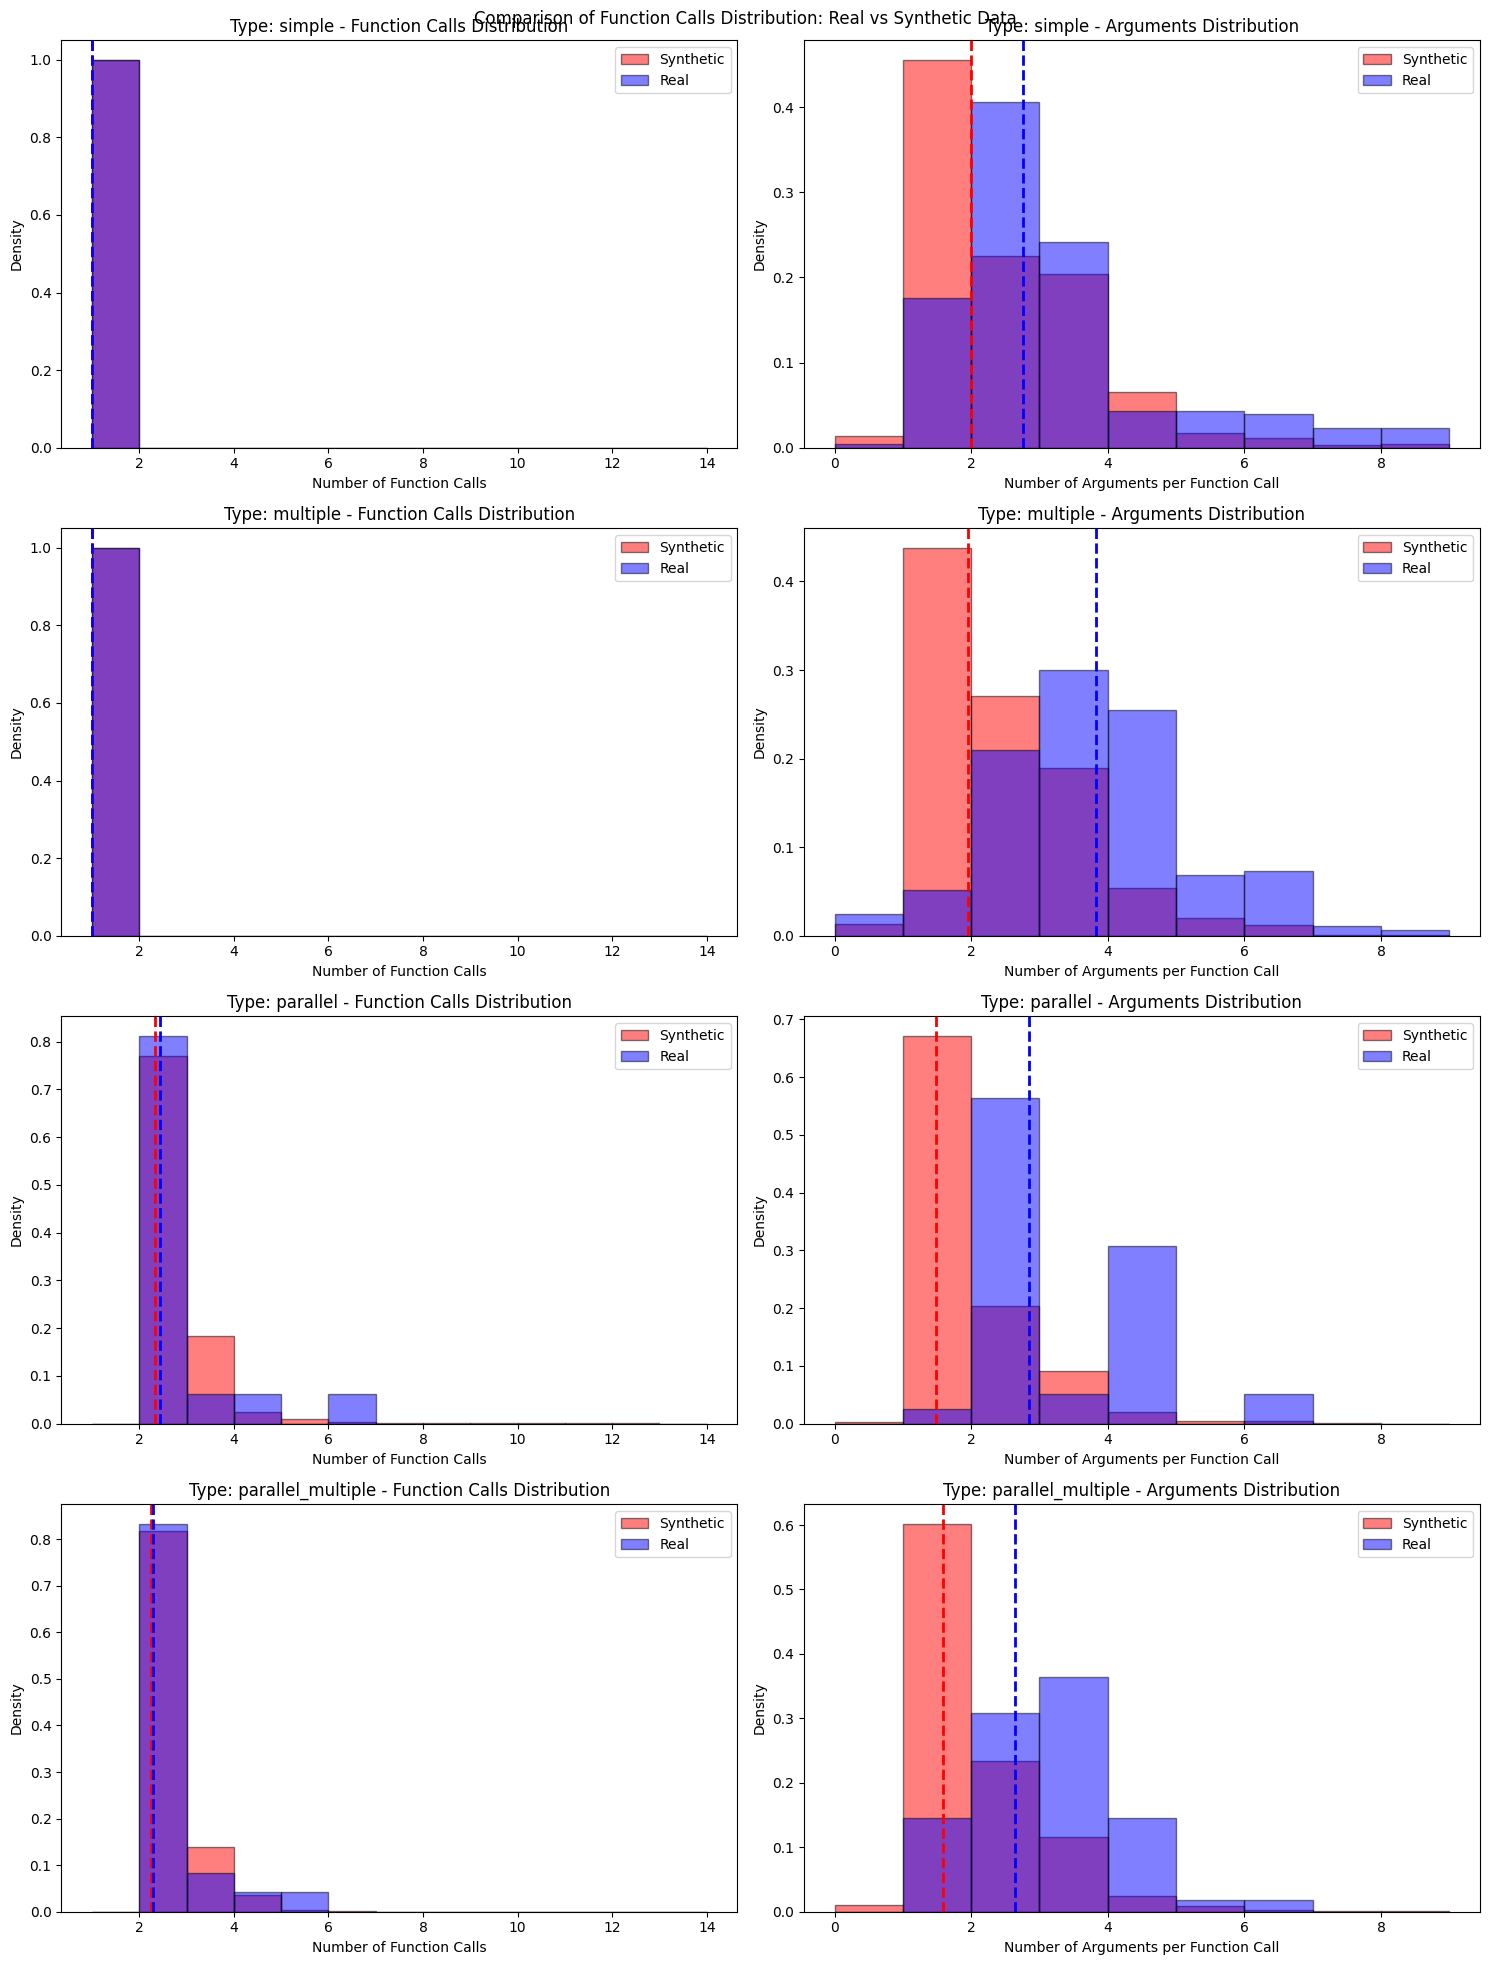

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Create subplot for analyzing function calls in all types
split_types = ['simple', 'multiple', 'parallel', 'parallel_multiple']
fig, axes = plt.subplots(4, 2, figsize=(15, 20))  # Changed to 4x2 layout
fig.suptitle('Comparison of Function Calls Distribution: Real vs Synthetic Data')

for idx, type_ in enumerate(split_types):
    # Count function calls for synthetic data
    synthetic_num_calls = [len(json.loads(item['answers'])) 
                          for item in apigen_datasets_classified[type_]]
    
    # Count function calls for real data
    real_num_calls = [len(item['ground_truth']) 
                     for item in real_data_answers[type_]]
    
    # Plot function calls distribution
    ax = axes[idx, 0]  # Changed indexing for 4x2 layout
    ax.hist(synthetic_num_calls, bins=range(1, 15, 1), alpha=0.5, 
            color='red', edgecolor='black', label='Synthetic', density=True)
    ax.hist(real_num_calls, bins=range(1, 15, 1), alpha=0.5, 
            color='blue', edgecolor='black', label='Real', density=True)
    
    ax.set_title(f'Type: {type_} - Function Calls Distribution')
    ax.set_xlabel('Number of Function Calls')
    ax.set_ylabel('Density')
    ax.legend()
    
    # Add mean lines
    synthetic_mean = np.mean(synthetic_num_calls)
    real_mean = np.mean(real_num_calls)
    ax.axvline(synthetic_mean, color='red', linestyle='dashed', linewidth=2)
    ax.axvline(real_mean, color='blue', linestyle='dashed', linewidth=2)
    
    # Print statistics
    print(f"\nFunction call statistics for {type_}:")
    print(f"Synthetic - Mean: {synthetic_mean:.2f}, Median: {np.median(synthetic_num_calls):.2f}")
    print(f"Real - Mean: {real_mean:.2f}, Median: {np.median(real_num_calls):.2f}")

    # Count arguments for synthetic data
    synthetic_num_args = []
    for item in apigen_datasets_classified[type_]:
        answers = json.loads(item['answers'])
        for answer in answers:
            synthetic_num_args.append(len(answer['arguments']))
    
    # Count arguments for real data
    real_num_args = []
    for item in real_data_answers[type_]:
        for answer in item['ground_truth']:
            # Get the first (and only) function name and its arguments
            func_name = list(answer.keys())[0]
            real_num_args.append(len(answer[func_name]))
    
    # Plot arguments distribution
    ax = axes[idx, 1]  # Changed indexing for 4x2 layout
    ax.hist(synthetic_num_args, bins=range(0, 10, 1), alpha=0.5,
            color='red', edgecolor='black', label='Synthetic', density=True)
    ax.hist(real_num_args, bins=range(0, 10, 1), alpha=0.5,
            color='blue', edgecolor='black', label='Real', density=True)
    
    ax.set_title(f'Type: {type_} - Arguments Distribution')
    ax.set_xlabel('Number of Arguments per Function Call')
    ax.set_ylabel('Density')
    ax.legend()
    
    # Add mean lines
    synthetic_mean_args = np.mean(synthetic_num_args)
    real_mean_args = np.mean(real_num_args)
    ax.axvline(synthetic_mean_args, color='red', linestyle='dashed', linewidth=2)
    ax.axvline(real_mean_args, color='blue', linestyle='dashed', linewidth=2)
    
    # Print statistics
    print(f"\nArgument statistics for {type_}:")
    print(f"Synthetic - Mean: {synthetic_mean_args:.2f}, Median: {np.median(synthetic_num_args):.2f}")
    print(f"Real - Mean: {real_mean_args:.2f}, Median: {np.median(real_num_args):.2f}")

plt.tight_layout()
plt.show()